The starting point for much of this notebook is based notes I transcribed from Dr. Alvarez's excellent ODSC presentation: "Understanding the PyTorch Framework with Applications to Deep Learning." 

In [1]:
# usual suspects
import os
import time
import shutil
import requests
import zipfile
from PIL import Image

import numpy as np
import pandas as pd
from cycler import cycler

# the good stuff
from sklearn.model_selection import train_test_split

import torch as to
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms

# standard sklearn import
from sklearn.metrics import accuracy_score

# minor changes to plotting functions
import matplotlib.pyplot as plt
cmap=plt.cm.tab10
c = cycler('color', cmap(np.linspace(0,1,10)))
plt.rcParams["axes.prop_cycle"] = c


%matplotlib inline
%config InlineBackend.figure_format='retina'

# change margin size of jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


In [2]:
# Download all necessary files for the live tutorial
# Post ODSC pull from GitHub Repo github.com/robert-alvarez

data_url = 'https://www.dropbox.com/s/z0ilg0u8rsl2udz/pytorch_data.zip?dl=1'#This dl=1 means it automatically downloads

if not os.path.exists('data'):
    # Download the data zip file.
    response = requests.get(data_url, stream=True)
    zip_path = 'pytorch_data.zip'
    with open(zip_path, 'wb') as f:
        shutil.copyfileobj(response.raw, f)
    # Unzip the file.
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall()
    # Clean up.
    os.remove(zip_path)

# 1. Basic Operations

In [87]:
#Random Tensor Generator
t2 = to.rand(2,3,4, dtype = to.float64)
print("Complete Tensor \n {} \n".format(t2))
print("\n First matrix slice inside tensor \n{}\n".format(t2[0]))
print("{} is on the first matrix, second row, second column".format(t2[0,2,2]))

Complete Tensor 
 tensor([[[0.1760, 0.6151, 0.7991, 0.2812],
         [0.2384, 0.3261, 0.7677, 0.7545],
         [0.0903, 0.0834, 0.2337, 0.7765]],

        [[0.7559, 0.2286, 0.5825, 0.5141],
         [0.1639, 0.7511, 0.8066, 0.6765],
         [0.7114, 0.6511, 0.4972, 0.0342]]], dtype=torch.float64) 


 First matrix slice inside tensor 
tensor([[0.1760, 0.6151, 0.7991, 0.2812],
        [0.2384, 0.3261, 0.7677, 0.7545],
        [0.0903, 0.0834, 0.2337, 0.7765]], dtype=torch.float64)

0.23365919850285022 is on the first matrix, second row, second column


In [105]:
#Explicit tensor creation
t3 = to.tensor([[[1,2],[3,4]],[[5,6],[7,8]]] , dtype = to.int)

In [106]:
# this method creates a new tensor "y" that has the same properties (e.g. dtype) as the original tensor "x"
y = t3.new_ones(2,1) #
print(y)

tensor([[1],
        [1]], dtype=torch.int32)


In [107]:
t3 @ y #Cross Product of 

tensor([[[ 3],
         [ 7]],

        [[11],
         [15]]], dtype=torch.int32)

In [93]:
t3 * t3 # dot product

tensor([[[ 1,  4],
         [ 9, 16]],

        [[25, 36],
         [49, 64]]], dtype=torch.int32)

In [94]:
t3 @ t3 # cross product

tensor([[[  7,  10],
         [ 15,  22]],

        [[ 67,  78],
         [ 91, 106]]], dtype=torch.int32)

In [95]:
t3 + t3

tensor([[[ 2,  4],
         [ 6,  8]],

        [[10, 12],
         [14, 16]]], dtype=torch.int32)

In [96]:
t3.add(t3) 

tensor([[[ 2,  4],
         [ 6,  8]],

        [[10, 12],
         [14, 16]]], dtype=torch.int32)

In [97]:
t3 

tensor([[[1, 2],
         [3, 4]],

        [[5, 6],
         [7, 8]]], dtype=torch.int32)

In [98]:
# The `*_` method works just like `inplace=True` in pandas
t3.add_(t3)

tensor([[[ 2,  4],
         [ 6,  8]],

        [[10, 12],
         [14, 16]]], dtype=torch.int32)

In [99]:
# We can reshape tensors as well though it's called "view" in pytorch
# support for 'reshape' has been added
x = to.randn(4,4)
y = x.view(16)
z = x.view(-1, 8)
w = x.reshape(2, -1)
print("x size = {},\ny size = {},\nz size = {},\nw size = {}".format(x.size(), y.size(), z.size(), w.size()))

x size = torch.Size([4, 4]),
y size = torch.Size([16]),
z size = torch.Size([2, 8]),
w size = torch.Size([2, 8])


In [102]:
#The x vector is flattened here
y

tensor([-0.4145, -1.1643,  2.1309, -1.1748,  0.1883,  0.5560,  0.2645, -1.0759,
        -0.2844, -0.5226, -1.3734,  0.4683, -0.0568, -0.3454, -0.7078, -0.1183])

In [103]:
a = to.ones(5)
b = a.numpy()
a.add(to.from_numpy(b)) # Cannot simply add numpy arrays and torch tensors

tensor([2., 2., 2., 2., 2.])

# 1b. Autograd

<b>autograd</b> allows automatic differentiation for all operations on Tensors.

In [138]:
# Create a tensor and set requires_grade=True 
# to track computation with it
x = to.ones(2,2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [139]:
# Because y was created as a result of an operation, 
# it now has a grad_fn method
y = 3*x + 7
print(y)

tensor([[10., 10.],
        [10., 10.]], grad_fn=<AddBackward0>)


In [140]:
# We can do more stuff to y (and thus x) and calculate its derivatives
z = 2*y**2
w = z.mean()

print("z: {},\nw: {}".format(z, w))

z: tensor([[200., 200.],
        [200., 200.]], grad_fn=<MulBackward0>),
w: 200.0


In [141]:
#Computes the gradient of current tensor w.r.t. graph leaves.
w.backward()

In [142]:
x.grad

tensor([[30., 30.],
        [30., 30.]])

# 1c. Linear Regression With Stochastic Gradient Descent

#### A simple linear regression model in PyTorch

#### Step #1: Basic Definitions of Data Space

In [232]:
n_data = 10_000
X = to.ones(n_data,2) 

#populate random points into X
X[:,0].uniform_(-1.15,1.15)

actual = to.tensor([np.random.uniform(-14,14),
                    np.random.uniform(-14,14)])

y = X @ actual + to.randn(n_data)/3

#### Step #2: Train/Test Split

There is no autocovariance in this toy data dataset, therefore a simple train test split will suffice. 

In [241]:
#Train test split
train_size = int(n_data * .75)
test_size = n_data - train_size

X_train, X_test = X[0 : train_size, :], X[train_size : n_data, :]
y_train, y_test = y[0 : train_size],    y[train_size : n_data]

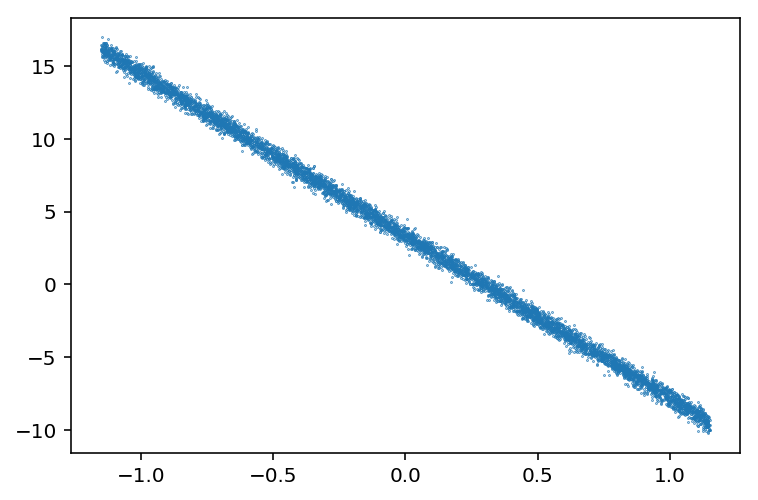

In [242]:
plt.scatter(X_train[:,0], y_train, s = .1);

#### Step #3: Define Scoring Function

In [243]:
def mean_standard_error(y, y_pred):
    return ((y - y_pred) ** 2).mean()

#### Step #4: Start with a arbitrary model to begin training 

In [244]:
#A random prediction
model = to.tensor([np.random.uniform(-14,14),
                   np.random.uniform(-14,14)])

y_hat = X_train @ model
mean_standard_error(y_hat, y_train)

tensor(464.4826)

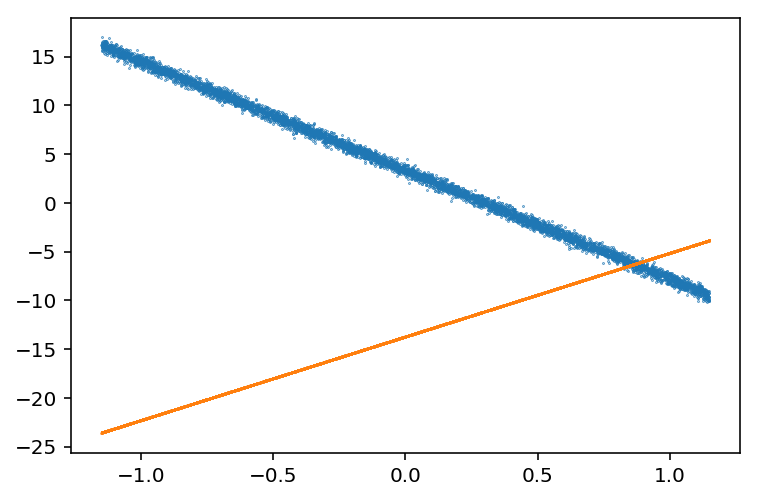

In [245]:
plt.scatter(X_train[:,0],y_train, s = .1)
plt.scatter(X_train[:,0],y_hat, s = .1);

#### Step #5: Parameterize the model

In [246]:
model = nn.Parameter(model)
model

Parameter containing:
tensor([  8.5788, -13.7045], requires_grad=True)

#### Bringing Step 1-5 together 

step:    5 MSE: 15.501243591308594
step:   10 MSE: 5.858819961547852
step:   15 MSE: 2.2898054122924805
step:   20 MSE: 0.9034123420715332
step:   25 MSE: 0.35734987258911133
step:   30 MSE: 0.14145243167877197
step:   35 MSE: 0.05600211024284363
step:   40 MSE: 0.022172898054122925
step:   45 MSE: 0.008779063820838928
step:   50 MSE: 0.003476053476333618
step:   55 MSE: 0.001376330852508545
step:   60 MSE: 0.0005449354648590088
step:   65 MSE: 0.00021576881408691406
step:   70 MSE: 8.542090654373169e-05
step:   75 MSE: 3.384798765182495e-05
step:   80 MSE: 1.3388693332672119e-05
step:   85 MSE: 5.304813385009766e-06
step:   90 MSE: 2.0638108253479004e-06
step:   95 MSE: 8.493661880493164e-07
step:  100 MSE: 3.3527612686157227e-07
step:  105 MSE: 1.2665987014770508e-07
step:  110 MSE: 5.960464477539063e-08
step:  115 MSE: 2.2351741790771484e-08

convergence of stochastic gradient descent at step 118


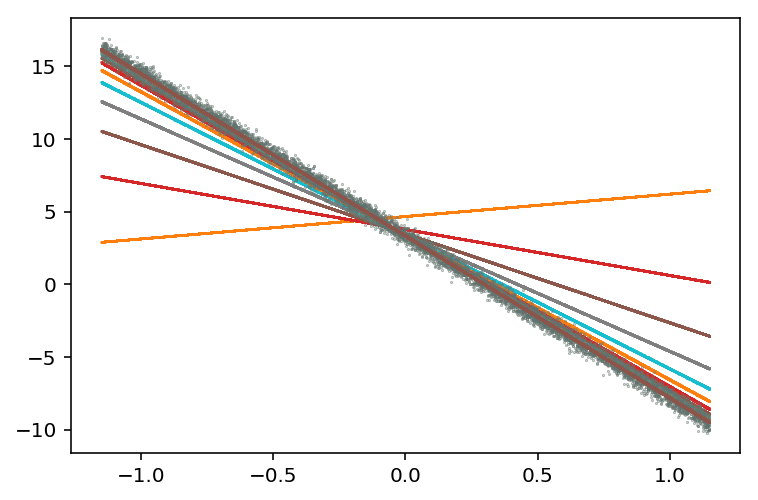

In [257]:
#A glorified stochastic gradient descent machine
def gentle_linear_torch(data, target, learning_rate, iterations):
    answer = {}
    def mean_standard_error(y_actual, y_pred):
        return ((y_actual - y_pred) ** 2).mean()
    
    #Random Initial Model
    model = nn.Parameter(to.tensor([np.random.uniform(-14,14),
                                    np.random.uniform(-14,14)]))

    y_hat = data @ model
    mean_standard_error(y_hat, target)

    for time in range(iterations):
        y_hat = data @ model
        loss = mean_standard_error(target, y_hat)
        
        if time > 0 and last_loss == loss:
            print("\nconvergence of stochastic gradient descent at step {}".format(time))
            return(model)
            break
        
        if time > 0 and time % 5 == 0:
            print("step: {:4} MSE: {:5}".format(time, float(last_loss.data - loss.data)))
            plt.scatter(data[:,0], target, s = .1, alpha = .05);
            plt.scatter(data[:,0], y_hat.detach().numpy(), s = .1);
        
        loss.backward()
        with to.no_grad():
            #These *_ set values like inplace = True
            model.sub_(learning_rate * model.grad) 
            model.grad.zero_()
        
        last_loss = loss
    
    print("\nmodel did not converge in max_iterations")
    return(model)

sgd = gentle_linear_torch( X_train, y_train, .1, 1000)

In [259]:
y_hat =  X_test @ sgd
float(mean_standard_error(y_hat, y_test))

0.10118553787469864

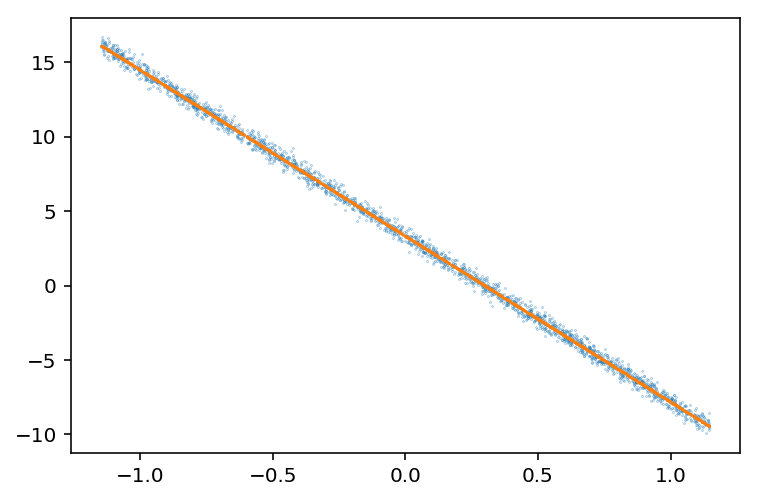

In [260]:
plt.scatter(X_test[:,0], y_test, s = .1, alpha = .5);
plt.scatter(X_test[:,0], y_hat.detach().numpy(), s = .1);

# 1d. Normal Equation Solution

Calculaing the linear regression with Ordinary least squares (OLS) estimator: <br><br>
$\hat{\boldsymbol{\beta}}=\left(\mathbf{X}^{\top} \mathbf{X}\right)^{-1} \mathbf{X}^{\top} \mathbf{y}$

In [263]:
theta = (to.t(X_train)@X_train).inverse() @ to.t(X_train) @ y_train
print(theta)
print(sgd)

tensor([-11.1565,   3.3413])
Parameter containing:
tensor([-11.1562,   3.3413], requires_grad=True)
